In [1]:
import sys; sys.path.append('..')
from osp import *
pd.options.display.max_colwidth = 200

In [2]:

comparisons = [
    (
        ('2000-2025 Philosophy', 'discipline=="Philosophy" & 2000<=year<2025'),
        ('2000-2025 Literature', 'discipline=="Literature" & 2000<=year<2025'),
    ),

    (
        ('1925-1950 Philosophy', 'discipline=="Philosophy" & 1925<=year<1950'),
        ('1925-1950 Literature', 'discipline=="Literature" & 1925<=year<1950'),
    ),

    (
        ('1950-1975 Philosophy', 'discipline=="Philosophy" & 1950<=year<1975'),
        ('1950-1975 Literature', 'discipline=="Literature" & 1950<=year<1975'),
    ),
    (
        ('1975-2000 Philosophy', 'discipline=="Philosophy" & 1975<=year<2000'),
        ('1975-2000 Literature', 'discipline=="Literature" & 1975<=year<2000'),
    ),
]


In [3]:
groups_train = comparisons[0]
df_scores_z = get_balanced_cv_data(groups_train)
df_scores_raw = get_balanced_cv_data(groups_train, normalize=False)

In [41]:
def is_numeric(x):
    try:
        float(x)
        return True
    except:
        return False


def get_top_word_egs(word2count, n=None, min_count=None, incl_count=False):
    # from .constants import FEAT_N, FEAT_MIN_COUNT
    word2count = Counter({x:int(i) for x,i in word2count.items() if is_numeric(i)})
    if n is None:
        n = FEAT_N
    
    total = word2count.total()
    words = []
    for w, c in word2count.most_common(n):
        c = int(round(c/total*1000))
        if not min_count or c >= min_count or len(words) >= n:
            words.append(w)
        else:
            break
    return words

def get_top_egs(egs_grp, words, n=None, min_count=None, incl_count=False):
    egs = []
    for w in words:
        eg=egs_grp.get(w, '')
        if eg:
            egs.append(eg)
        if len(egs) >= n:
            break
    return egs

def get_top_egs_str(top_egs):
    return '; '.join(f'“{e}”' for e in top_egs)

def get_top_word_egs_str(top_words):
    return ', '.join(f'{w}' for w in top_words)


In [42]:
def get_mdw_feats(groups_train, feat_n=10, feat_n_egs=5):
    name1,q1 = groups_train[0]
    name2,q2 = groups_train[1]
    ids1=get_corpus_metadata().query(q1).index.tolist()
    ids2=get_corpus_metadata().query(q2).index.tolist()
    cols = set(df_scores_z.columns) & set(df_scores_raw.columns)
    hdr = '_group'
    words_grp1 = get_pos_word_counts(ids1)
    words_grp2 = get_pos_word_counts(ids2)
    egs_grp1 = get_pos_word_egs(ids1)
    egs_grp2 = get_pos_word_egs(ids2)
    feats = [f for f in cols if f[0]!='_']
    o = []
    for feat in feats:
        feat_name = feat.split('_')[-1]
        dfx_z = df_scores_z.groupby(hdr)[feat].mean()
        dfx_raw = df_scores_raw.groupby(hdr)[feat].mean()
        words1 = get_top_word_egs(words_grp1.get(feat_name, {}), n=feat_n, incl_count=True)
        words2 = get_top_word_egs(words_grp2.get(feat_name, {}), n=feat_n, incl_count=True)
        egs1 = get_top_egs(egs_grp1.get(feat_name, {}), words1, n=feat_n_egs, incl_count=False)
        egs2 = get_top_egs(egs_grp2.get(feat_name, {}), words2, n=feat_n_egs, incl_count=False)
        words1_str = get_top_word_egs_str(words1)
        words2_str = get_top_word_egs_str(words2)
        egs1_str = get_top_egs_str(egs1)
        egs2_str = get_top_egs_str(egs2)
        out_d = {
            'feature': feat,
            'feat_desc': FEAT2DESC.get(feat_name, ''),
            'score_mean0': dfx_raw.loc['Unseen'],
            'score_mean1': dfx_raw.loc[name1],
            'score_mean2': dfx_raw.loc[name2],
            'score_mean_diff': dfx_raw.loc[name1] - dfx_raw.loc[name2],
            'score_mean_div': dfx_raw.loc[name1] / dfx_raw.loc[name2] if dfx_raw.loc[name2]!=0 else None,
            'score_z0': dfx_z.loc['Unseen'],
            'score_z1': dfx_z.loc[name1],
            'score_z2': dfx_z.loc[name2],
            'score_z_diff': dfx_z.loc[name1] - dfx_z.loc[name2],
            'words1': words1_str,
            'words2': words2_str,
            'egs1': egs1_str,
            'egs2': egs2_str,
        }
        o.append(out_d)
    odf=pd.DataFrame(o).sort_values('score_z_diff', ascending=False).set_index('feature')
    return odf

In [43]:
get_mdw_feats(groups_train)

,feat_desc,score_mean0,score_mean1,score_mean2,score_mean_diff,score_mean_div,score_z0,score_z1,score_z2,score_z_diff,words1,words2,egs1,egs2
feature,,,,,,,,,,,,,,
deprel_cop,Copula,25.099443,27.002293,16.890811,10.111482,1.598638,0.074195,0.316526,-0.859847,1.176373,"is, are, be, being, was, were, 's, am, been, s","is, are, was, be, were, been, being, 's, am, 're","“following statement IS then straightforward”; “statements that ARE useful to compare”; “To BE precise, we intend”; “responsible, but BEING responsible also”; “evolutionary selection WAS at best r...",“particular institutions IS immaterial since”; “to al - Tiba ARE most often those”; “the mid-nineties WAS indeed representative”; “decades tended to BE in the West”; “because they WERE permanent...
deprel_mark,Marker,42.923203,49.056194,32.569007,16.487187,1.506223,0.053664,0.475065,-0.678818,1.153883,"to, that, if, as, of, for, in, by, because, whether","to, that, as, if, of, in, by, because, for, while","“that are useful TO compare the logical”; “Thirdly, we note THAT the elementary”; “IF this new perspective”; “definitions in CL, AS follows”; “defined as a class OF preparing devices”","“The books TO be read are selected”; “The fact THAT American literature”; “such curricula, AS it did at Washington”; “But IF this metareflection”; “irrespective OF whether or not”"
sent_num_dependent_clauses,,43.577088,49.157527,34.599094,14.558433,1.420775,0.045081,0.484765,-0.647092,1.131857,,,,
pos_MD,Modal,14.968098,16.591005,8.899210,7.691795,1.864323,0.070529,0.318762,-0.795253,1.114015,"can, will, would, may, might, should, could, must, shall, ought","can, would, will, may, could, might, must, should, shall, 'd","“way, but it CAN be provided with”; “The answer WILL be so context”; “specifically, he WOULD observe that we”; “however, one MAY wonder whether”; “While anger MIGHT be a good epistemic”",“the topographies CAN be understood as”; “American literature WOULD experience decades”; “following pages I WILL present three detailed”; “such a statement MAY be too totalizing”; “territory who C...
sent_height,,494.789255,523.078632,455.045809,68.032823,1.149508,0.043305,0.503897,-0.607428,1.111325,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pos_NNP,"Proper noun, singular",26.117965,20.901342,43.862800,-22.961458,0.476516,-0.055461,-0.270260,0.700677,-0.970937,"s, a, c, sect, t, god, f, university, kant, aristotle","god, english, new, john, england, la, derrida, united, milton, shakespeare",“Axiom P { ext (S) S G is a partition”; “Sf I > ext (A) G ¿”; “dependent notion of C - truth { true”; “We obtain in SECT”; “given theory T and classical language”,"“their duty to GOD, to their mother”; “called Spoken ENGLISH ), Drama, and”; “Fiction and Film (NEW York and Oxford”; “the example of JOHN Bunyan, author”; “most others in ENGLAND during this p..."
pos_NNPS,"Proper noun, plural",0.983273,0.502151,2.569991,-2.067840,0.195390,-0.059019,-0.283827,0.687842,-0.971670,"states, humeans, principles, netherlands, greeks, essays, reasons, stoics, sciences, fregeans","states, americans, jews, studies, ages, indians, works, palestinians, letters, notes",“STATES are defined as”; “is one that HUMEANS in particular should”; “Harm and Offense PRINCIPLES (suitably supplemented”; “Printed in the NETHERLANDS”; “those of the GREEKS”,“the United STATES of the latter nineteenth”; “citizenship to black AMERICANS in the United States”; “possibilities that the JEWS and their conceptually”; “Figurai Realism : STUDIES in the Mimesis...
deprel_conj,Conjunct,32.720719,26.999297,40.598640,-13.599342,0.665030,-0.042541,-0.504938,0.601854,-1.106792,"have, not, b, al, etc, is, one, has, on, what","one, political, what, history, cultural, have, culture, others, language, form","“equal, but we HAVE an overriding interest”; “Whether or NOT such a reduction”; “or just before B) all take the”; “Schervish et AL”; “phenomenon and data, ETC”","“Tennyson, and ONE on American poets”; “economic and POLITICAL 

In [9]:
df_mdw=get_mdw_feats(groups_train)
df_mdw

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [6]:
df_mdw

,feat_desc,score_mean0,score_mean1,score_mean2,score_mean_diff,score_mean_div,score_z0,score_z1,score_z2,score_z_diff,words1,words2,egs1,egs2
feature,,,,,,,,,,,,,,
deprel_cop,Copula,25.057558,27.343189,16.890811,10.452378,1.618820,0.074102,0.317280,-0.859847,1.177127,is are be being was were 's am been s,is are was be were been being 's am 're,"""49441"" ""13700"" ""13511"" ""2693"" ""1534""","""9195"" ""2056"" ""2010"" ""1847"" ""697"""
deprel_mark,Marker,42.949059,48.845757,32.569007,16.276750,1.499762,0.054217,0.470565,-0.678818,1.149383,to that if as of for in by because whether,to that as if of in by because for while,"""48446"" ""42092"" ""11890"" ""9480"" ""5337""","""12861"" ""5977"" ""3219"" ""1392"" ""1391"""
sent_num_dependent_clauses,,43.559289,49.302396,34.599094,14.703302,1.424962,0.045599,0.480548,-0.647092,1.127640,,,,
pos_MD,Modal,14.959959,16.657241,8.899210,7.758032,1.871766,0.072733,0.300826,-0.795253,1.096079,can will would may might should could must shall ought,can would will may could might must should shall 'd,"""14241"" ""7846"" ""7440"" ""4622"" ""4152""","""2122"" ""1516"" ""1169"" ""900"" ""815"""
sent_height,,494.865454,522.458455,455.045809,67.412646,1.148145,0.045360,0.487175,-0.607428,1.094602,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
deprel_nmod:poss,Possessive nominal modifier,17.556717,12.862159,22.424873,-9.562715,0.573567,-0.006112,-0.481148,0.497439,-0.978586,our their its his my her your one whose agent,his its their her our my whose your one novel,"""6295"" ""5556"" ""4995"" ""4465"" ""3643""","""5384"" ""2837"" ""2547"" ""1618"" ""1049"""
pos_NNP,"Proper noun, singular",26.150418,20.637214,43.862800,-23.225586,0.470495,-0.053016,-0.290156,0.700677,-0.990833,s a c sect t god f university kant aristotle,god english new john england la derrida united milton shakespeare,"""927"" ""810"" ""717"" ""677"" ""618""","""319"" ""272"" ""243"" ""202"" ""188"""
deprel_conj,Conjunct,32.716772,27.031428,40.598640,-13.567212,0.665821,-0.042726,-0.503435,0.601854,-1.105289,have not b al etc is one has on what,one political what history cultural have culture others language form,"""511"" ""363"" ""344"" ""326"" ""324""","""126"" ""104"" ""100"" ""95"" ""87"""


In [7]:
dfx_z

NameError: name 'dfx_z' is not defined

In [ ]:
odf[odf.feature=='sent_height'].sort_values('score_z', ascending=False)

,_target,_group,_type,feature,score_mean,score_z
196,Philosophy,2000-2025 Philosophy,CV,sent_height,521.320363,0.488191
294,Philosophy,Unseen,Unseen,sent_height,509.329024,0.279119
98,Literature,Unseen,Unseen,sent_height,459.960503,-0.526990
0,Literature,2000-2025 Literature,CV,sent_height,455.045809,-0.607428


In [ ]:
out_d

{'_target': 'Literature', '_group': '2000-2025 Literature', '_type': 'CV'}

'CV'

In [ ]:
def classify_then_predict(groups_train, target_col='discipline', balance=True, num_runs=1, verbose=False, **kwargs):
    l_preds=[]
    l_feats=[]
    for nrun in tqdm(list(range(num_runs))):
        df_scores = get_balanced_cv_data(groups_train, target_col=target_col, balance=balance)

        cv_preds, cv_feats, cv_model = classify_data(
            df_scores.query('_type=="CV"').drop(columns=['_type']),
            target_col='_target',
            verbose=verbose,
            balance=False,
            **kwargs
        )
        
        new_target = df_scores._target.tolist()
        new_probs = cv_model.predict_proba(df_scores.drop(columns=['_type','_target']))
        df_new_probs = pd.DataFrame(new_probs)
        df_new_probs.columns = cv_model.classes_
        df_new_probs['pred_label'] = df_new_probs.idxmax(axis=1)
        df_new_probs.columns = ['prob1','prob2','pred_label']
        df_new_probs['true_label'] = new_target
        df_new_probs['correct'] = (df_new_probs['pred_label'] == df_new_probs['true_label']).apply(int)
        df_new_probs['test_label'] = ' / '.join(cv_model.classes_)
        df_new_probs['id'] = df_scores.index
        df_new_probs['predict_type'] = 'unseen'
        df_new_probs.set_index('id', inplace=True)
        # df_new_probs
        l_preds.append(df_new_probs.assign(run=nrun))
        l_feats.append(cv_feats.assign(run=nrun))
    
    df_preds = pd.concat(l_preds)
    df_feats = pd.concat(l_feats)
    return df_preds, get_df_feats_with_pos_mdw(df_feats, groups_train)

In [ ]:
df_preds, df_feats = run_comparison(comparisons,num_runs=1,sample_size=1000)

## 2000-2025 Philosophy vs 2000-2025 Literature


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]



## 1925-1950 Philosophy vs 1925-1950 Literature


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



## 1950-1975 Philosophy vs 1950-1975 Literature


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]



## 1975-2000 Philosophy vs 1975-2000 Literature


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


In [ ]:
df_preds

,prob1,prob2,pred_label,true_label,correct,test_label,predict_type,run,comparison
id,,,,,,,,,
lit/10.1086/421163__03,0.168683,0.831317,Philosophy,Literature,0,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature
lit/1261520__04,0.996775,0.003225,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature
lit/20467431__01,0.998006,0.001994,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature
lit/25501628__01,0.984552,0.015448,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature
lit/24542550__02,0.996742,0.003258,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature
...,...,...,...,...,...,...,...,...,...
lit/459015__01,0.910524,0.089476,Literature,Literature,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature
lit/27760277__03,0.534066,0.465934,Literature,Literature,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature
lit/30031939__01,0.940559,0.059441,Literature,Literature,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature


In [ ]:
# df_feats

In [ ]:
df_preds['text_id'] = [i.split('__')[0] for i in df_preds.index]
df_preds["correct"] = [
    int(x == y) for x, y in zip(df_preds["pred_label"], df_preds["true_label"])
]
odf = (
    df_preds.rename_axis("slice_id")
    .reset_index()
    .merge(
        get_corpus_metadata()[["year", "decade", "discipline", "journal"]],
        left_on="text_id",
        right_on="id",
        how="left",
    )
)
odf
# odf.to_csv('../data/preds3.csv')

,slice_id,prob1,prob2,pred_label,true_label,correct,test_label,predict_type,run,comparison,text_id,year,decade,discipline,journal
0,lit/10.1086/421163__03,0.168683,0.831317,Philosophy,Literature,0,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature,lit/10.1086/421163,2004,2000,Literature,Critical Inquiry
1,lit/1261520__04,0.996775,0.003225,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature,lit/1261520,2003,2000,Literature,PMLA
2,lit/20467431__01,0.998006,0.001994,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature,lit/20467431,2007,2000,Literature,The Modern Language Review
3,lit/25501628__01,0.984552,0.015448,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature,lit/25501628,2006,2000,Literature,PMLA
4,lit/24542550__02,0.996742,0.003258,Literature,Literature,1,Literature / Philosophy,unseen,0,2000-2025 Philosophy vs 2000-2025 Literature,lit/24542550,2014,2010,Literature,New Literary History
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126123,lit/459015__01,0.910524,0.089476,Literature,Literature,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature,lit/459015,1941,1940,Literature,PMLA
126124,lit/27760277__03,0.534066,0.465934,Literature,Literature,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature,lit/27760277,2009,2000,Literature,New Literary History
126125,lit/30031939__01,0.940559,0.059441,Literature,Literature,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature,lit/30031939,2000,2000,Literature,ELH
126126,phil/10.2307/2025409__04,0.000250,0.999750,Philosophy,Philosophy,1,Literature / Philosophy,unseen,0,1975-2000 Philosophy vs 1975-2000 Literature,phil/10.2307/2025409,1979,1970,Philosophy,The Journal of Philosophy


,year,discipline,comparison,mean,stderr,count
0,2018,Philosophy,1975-2000 Philosophy vs 1975-2000 Literature,0.964669,0.004633,530
1,2017,Philosophy,1975-2000 Philosophy vs 1975-2000 Literature,0.959368,0.005858,481
2,2021,Philosophy,1975-2000 Philosophy vs 1975-2000 Literature,0.957425,0.003085,1552
3,2016,Philosophy,1975-2000 Philosophy vs 1975-2000 Literature,0.954423,0.006770,460
4,2007,Philosophy,1975-2000 Philosophy vs 1975-2000 Literature,0.953158,0.006453,371
...,...,...,...,...,...,...
759,1954,Literature,1975-2000 Philosophy vs 1975-2000 Literature,0.043462,0.010107,80
760,1965,Literature,2000-2025 Philosophy vs 2000-2025 Literature,0.035818,0.008372,94
761,1946,Literature,2000-2025 Philosophy vs 2000-2025 Literature,0.032075,0.006721,85
762,2017,Literature,2000-2025 Philosophy vs 2000-2025 Literature,0.022819,0.010881,21


In [ ]:
# !pip install scikit-misc

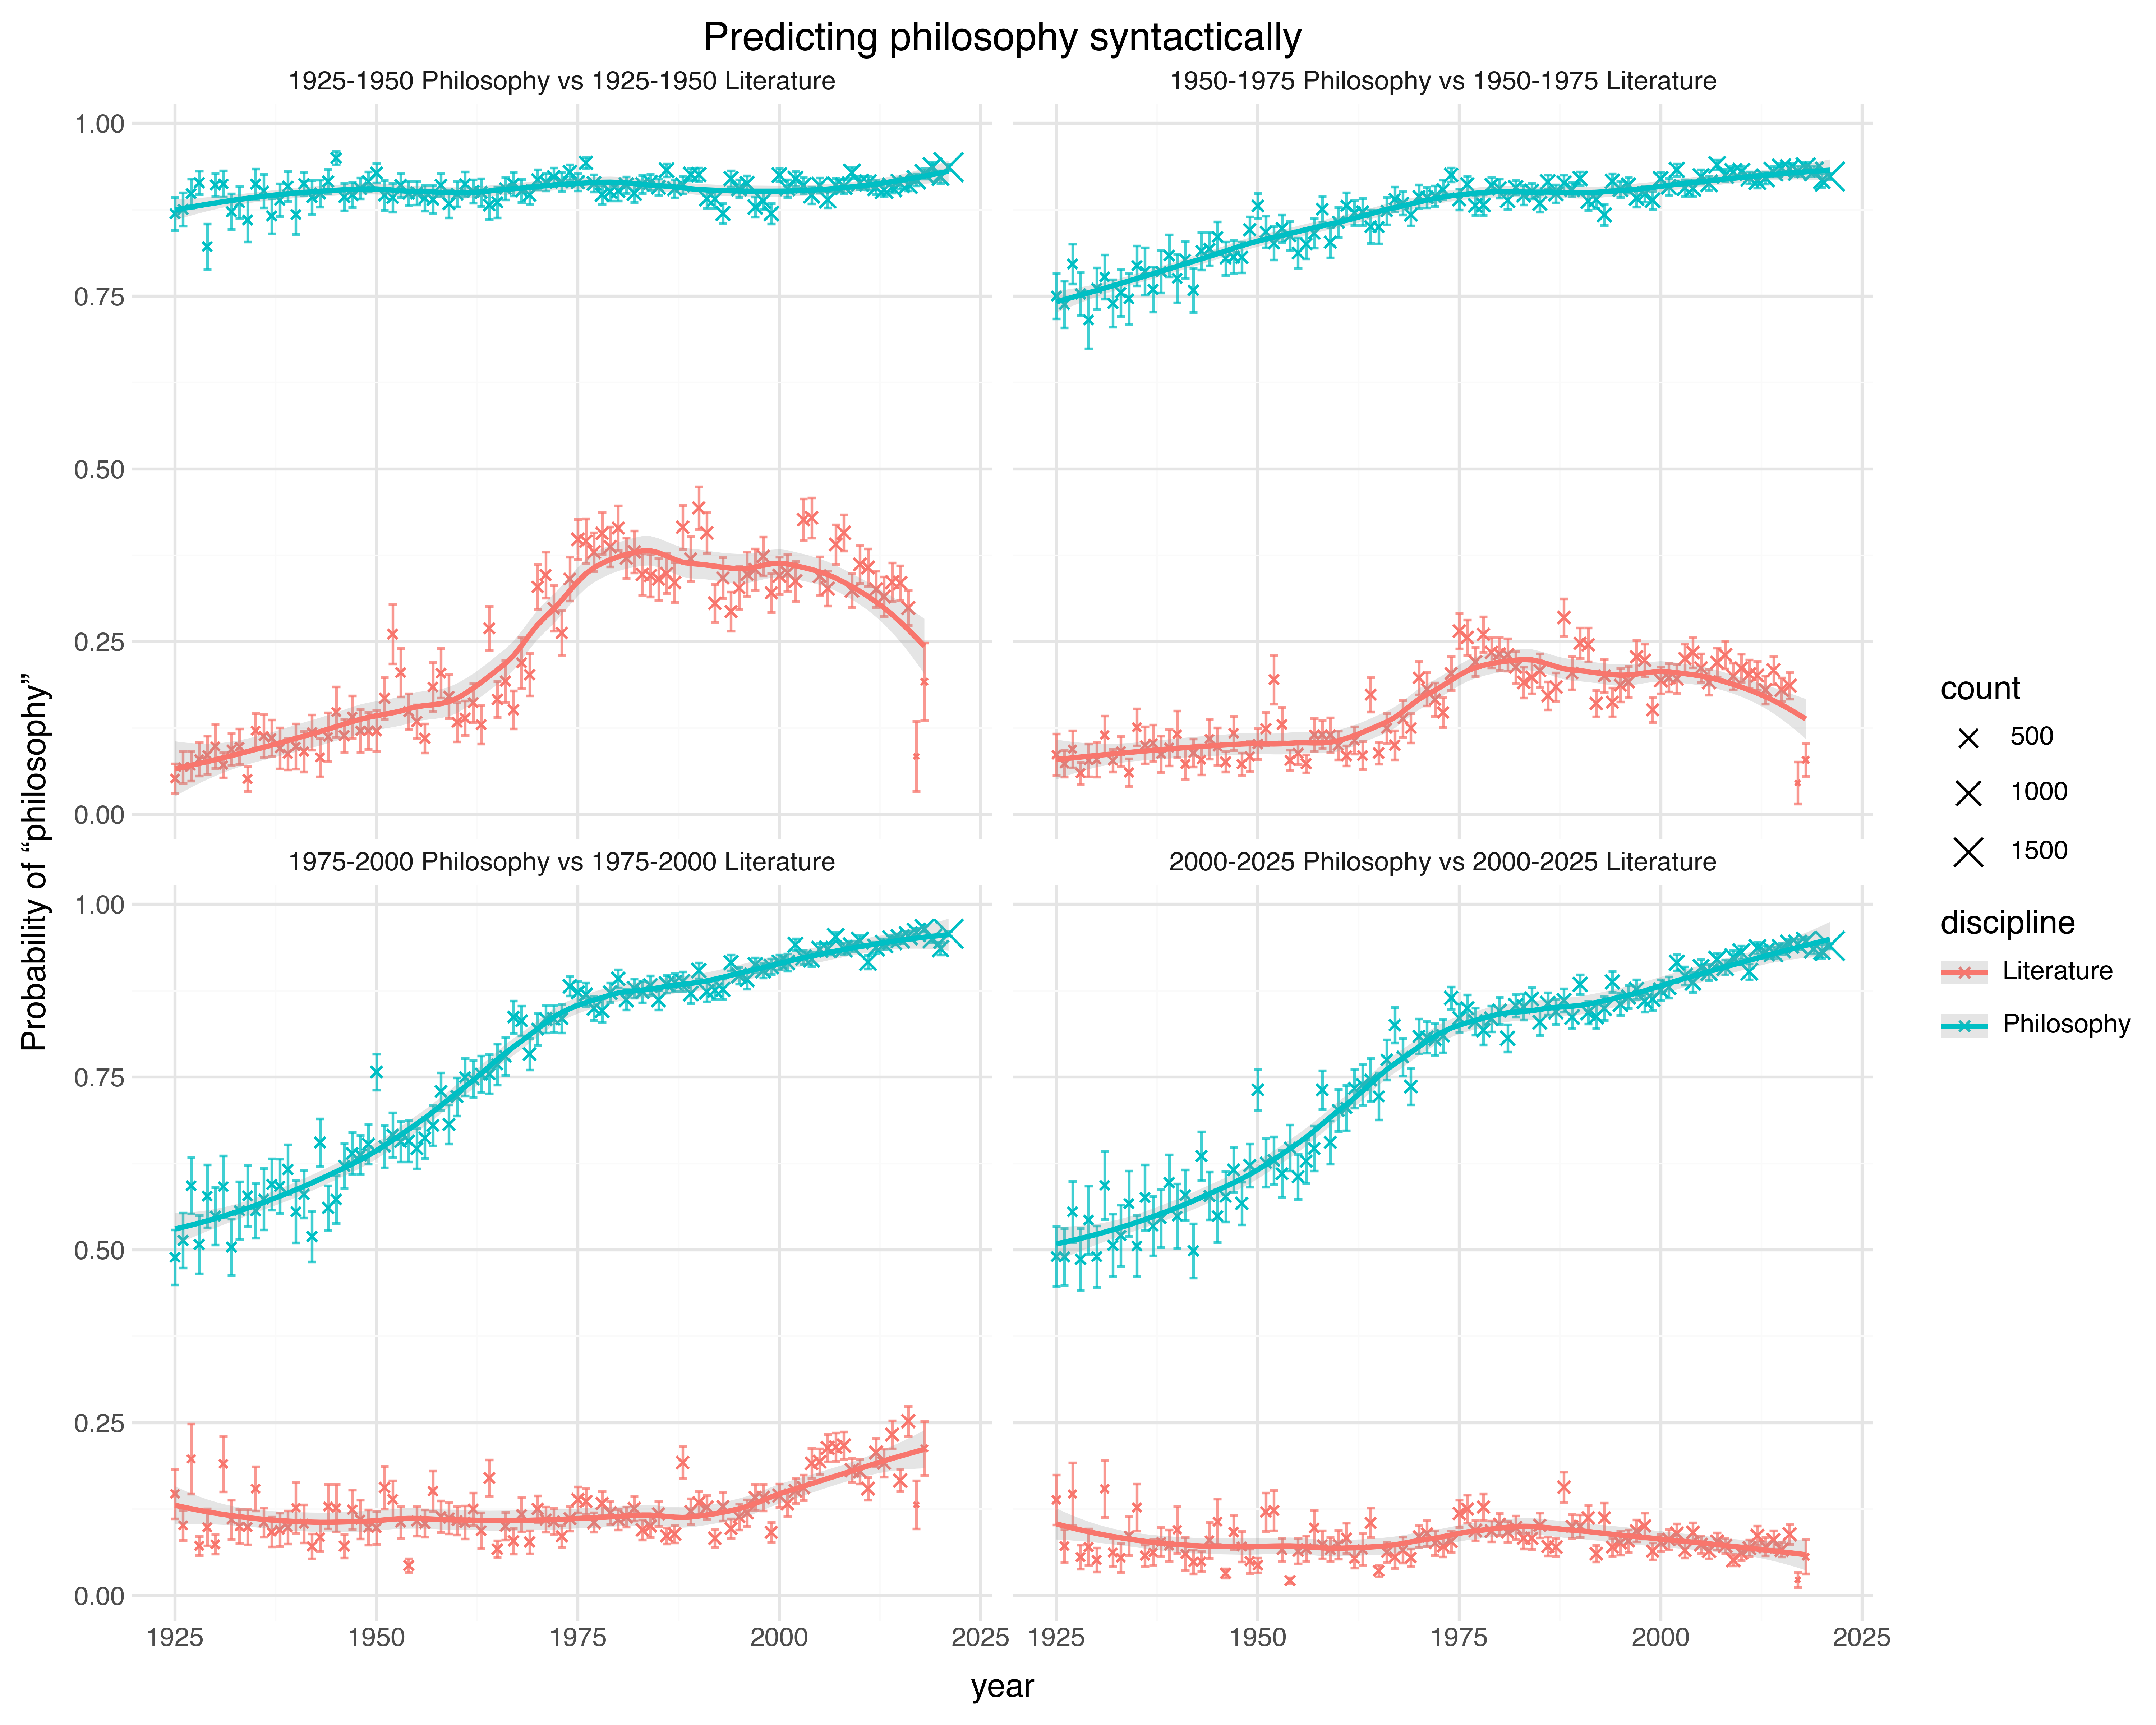

In [ ]:
figdf = get_avgs_df(odf,y='prob2').reset_index()
plot_avgs_df(figdf, title="Predicting philosophy syntactically", y="Probability of “philosophy”")

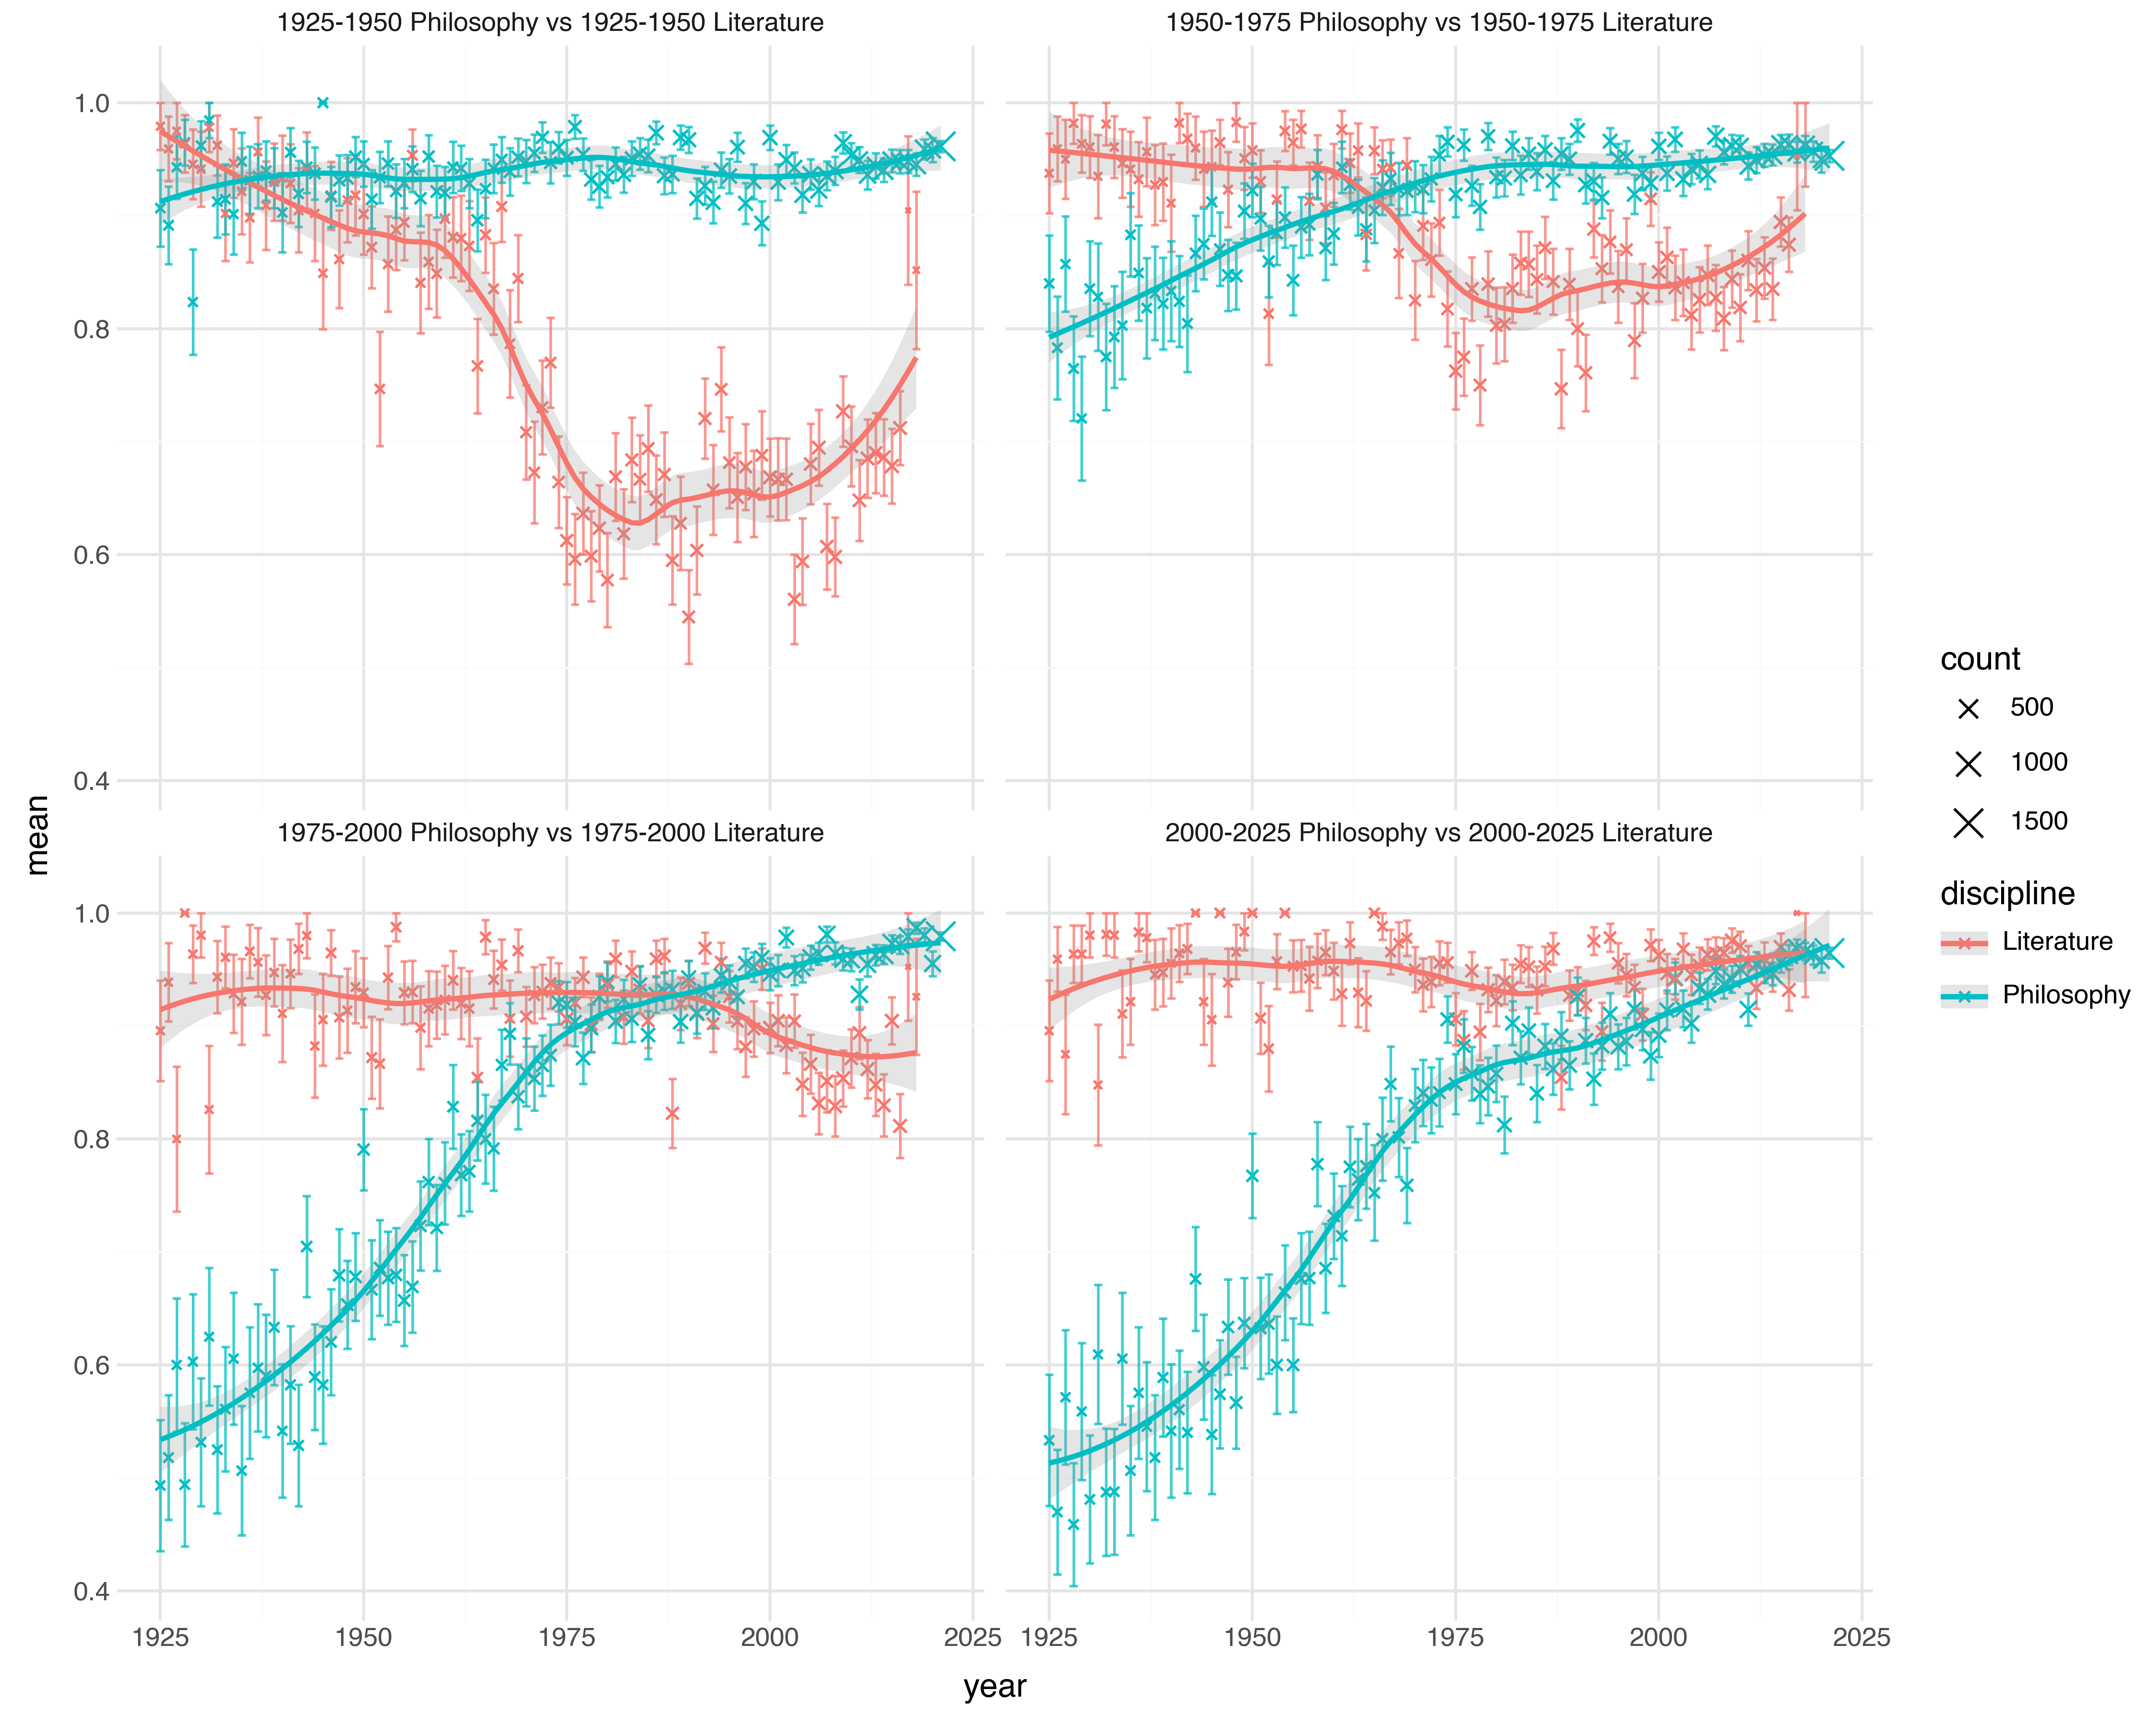

In [ ]:
figdf = get_avgs_df(odf,y='correct').reset_index()
plot_avgs_df(figdf)

In [ ]:
dfx=df_feats.groupby('feature').mean(numeric_only=True).sort_values('weight', ascending=False)

In [ ]:
dfx.tail(20)

,weight,run,fpk1,fpk2,odds_ratio,sum1,sum2,mdw_rank,mdw1_rank,mdw2_rank,feat1_rank,feat2_rank,feat_rank
feature,,,,,,,,,,,,,
deprel_obj,-0.150373,0.0,37.500,38.400,0.975,53499.00,26396.75,85.00,57.25,40.50,63.00,40.00,51.50
deprel_iobj,-0.158181,0.0,0.725,1.100,0.675,1003.25,736.00,30.00,81.25,16.50,73.25,29.75,60.25
pos_WRB,-0.178985,0.0,3.825,3.375,1.150,5582.25,2305.75,68.00,35.25,62.50,73.75,29.25,59.25
pos_RB,-0.180454,0.0,49.775,43.625,1.125,68665.75,29767.50,64.50,34.50,63.25,67.00,36.00,48.25
"pos_,",-0.184004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.75,42.25,46.25
pos_VBN,-0.187070,0.0,23.225,24.325,0.975,30718.50,16304.25,87.25,58.00,39.75,73.25,29.75,58.75
ttr,-0.239154,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.75,31.25,12.50
deprel_root,-0.255013,0.0,37.150,36.650,1.025,51508.00,24552.50,78.75,52.50,45.25,69.00,34.00,24.75
deprel_dep,-0.255596,0.0,0.350,0.600,0.625,537.75,380.25,31.75,81.00,16.75,80.25,22.75,46.75


In [ ]:
dfx.head(30)

,weight,run,fpk1,fpk2,odds_ratio,sum1,sum2,mdw_rank,mdw1_rank,mdw2_rank,feat1_rank,feat2_rank,feat_rank
feature,,,,,,,,,,,,,
deprel_mark,0.651207,0.0,45.650,32.850,1.375,64506.00,22465.50,40.00,19.25,78.50,19.50,83.50,29.00
pos_SYM,0.610825,0.0,0.275,0.150,2.000,542.00,98.75,11.75,45.25,52.50,13.75,89.25,28.00
pos_MD,0.598494,0.0,16.600,10.050,1.700,22976.00,6728.00,24.00,11.75,86.00,11.25,91.75,18.75
sent_height,0.576012,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.75,87.25,26.75
pos_DT,0.554924,0.0,103.200,103.100,1.000,139478.75,70369.75,92.25,52.50,45.25,10.25,92.75,18.25
deprel_advmod,0.506523,0.0,54.875,48.700,1.125,75923.25,33161.50,68.75,37.50,60.25,17.25,85.75,32.00
pos_VB,0.484311,0.0,37.775,27.500,1.375,53054.25,18674.50,39.75,19.25,78.50,13.25,89.75,28.75
deprel_nmod,0.465539,0.0,53.025,56.300,0.950,70886.00,38709.25,77.50,59.25,38.50,14.25,88.75,29.50
pos_NN,0.440901,0.0,148.800,144.250,1.050,204647.50,100388.25,84.00,47.25,50.50,25.75,77.25,49.50


In [ ]:
df_preds.groupby()

,prob1,prob2,pred_label,true_label,test_label,predict_type,run,comparison,text_id
id,,,,,,,,,
lit/20057585__05,0.521719,0.478281,Literature,Literature,Literature / Philosophy,unseen,0,C21 Philosophy vs C21 Literature,lit/20057585
lit/27654619__02,0.779358,0.220642,Literature,Literature,Literature / Philosophy,unseen,0,C21 Philosophy vs C21 Literature,lit/27654619
lit/40963178__02,0.387011,0.612989,Philosophy,Literature,Literature / Philosophy,unseen,0,C21 Philosophy vs C21 Literature,lit/40963178
lit/10.1086/658327__05,0.649940,0.350060,Literature,Literature,Literature / Philosophy,unseen,0,C21 Philosophy vs C21 Literature,lit/10.1086/658327
lit/30031962__02,0.634543,0.365457,Literature,Literature,Literature / Philosophy,unseen,0,C21 Philosophy vs C21 Literature,lit/30031962
...,...,...,...,...,...,...,...,...,...
phil/10.2307/4544337__03,0.614292,0.385708,Literature,Philosophy,Literature / Philosophy,unseen,9,lC20 Philosophy vs lC20 Literature,phil/10.2307/4544337
lit/459015__01,0.742329,0.257671,Literature,Literature,Literature / Philosophy,unseen,9,lC20 Philosophy vs lC20 Literature,lit/459015
lit/27760277__03,0.542627,0.457373,Literature,Literature,Literature / Philosophy,unseen,9,lC20 Philosophy vs lC20 Literature,lit/27760277
